### Question 4

The code below uses Monte-Carlo simulation code to replicate Figures 8(a) and 8(b) of the An Introduction
to Derivatives Pricing lecture notes.While the original figures simulate 100,000 paths and have 2000 time periods per path, here we only simulate 5000 paths and 1000 perods per path.However, the distribution of the figures are identical. 

The figure below is the Delta-hedging P&L, given true vol. = 30%, and imp. vol. = 20%.

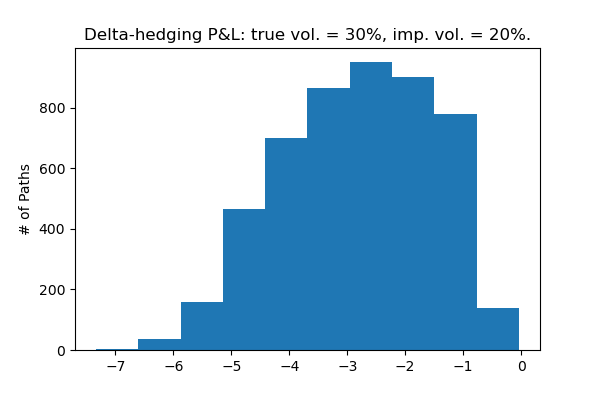

In [3]:
Image(filename='20%.png')

The figure below is the Delta-hedging P&L, given true vol. = 30%, and imp. vol. = 40%.

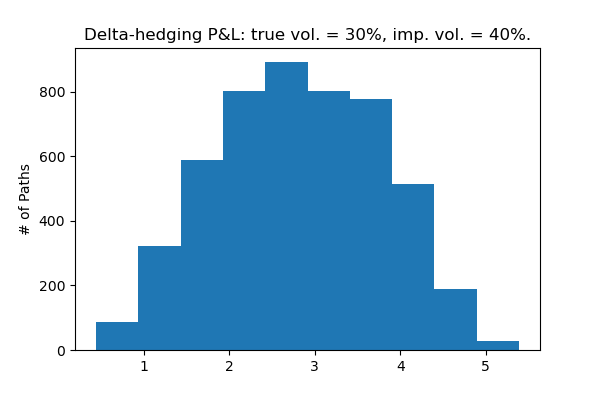

In [4]:
Image(filename='40%(1).png')

If the true volatility is equal to the implied volatility, then the histograms will look like a normal distribution, and the average is 0

### The code that draw the figures above are attached below

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
import math
from scipy.stats import norm
from IPython.display import Image

#### The stock price is simulated using Monte-Carlo simulation in R, assuming the stock price follows GBM

In [5]:
Stock_price=pd.read_csv('stock_price.csv',index_col=0)

In [15]:
S0 = 100 # Underlying price of stock at t = 0
K = 100 # strike price
r = 0.01 # continuously compounded risk-free interest rate
q = 0.01 # continuously compounded dividend yield
T = 0.5 #  option maturity
N = len(Stock_price.columns)-1 # number of periods

t = 0 # the current time

sigma = 0.4 # implied vol used to generate prices
number_path = len(Stock_price.index)

#### Calcating the C0 (option price at t = 0)

In [16]:
def C_Price(S, K, r, q, T,t,sigma): 
    d1 =  (math.log(S/K) + (r - q + (math.pow(sigma,2))/2)*(T-t)) / (sigma*math.sqrt((T-t)))
    d2 =  d1 - sigma*math.sqrt((T-t))
    C_Price = S * math.exp(-q*(T-t)) *  norm.cdf(d1) - K*math.exp(-r*(T-t))*norm.cdf(d2) # Calculating The Black-Scholes Option Price
    return C_Price
C0 = C_Price(S0, K, r, q,T, t, sigma)
C0

11.190200488459205

#### Creating the delta at each time period baesd on stock price 

In [8]:
def C_Delta(S,index): 
    """
    input: stock price, and the time
    output: delta at time i
    Calculate the delta based on stock price
    """
    ti = 1/N*T*index
    d1  =  (math.log(S/K) + (r + (math.pow(sigma,2))/2)* (T-ti)) / (sigma*math.sqrt(T-ti))
    C_Delta = math.exp(-q*(T-ti)) *  norm.cdf(d1)  # Calculating the delta
    return C_Delta

def return_which_period(value,row):
    row =list(row)
    return row.index(value)

def C_Delta_row(row):
    delta_row = []
    for element in row[:-1]:
        delta_row.append(C_Delta(element,return_which_period(element,row)))
    return delta_row

GBM_Delta = Stock_price.copy().iloc[: , :-1]
for i in range(len(Stock_price.index)):
    GBM_Delta.iloc[i] = C_Delta_row(Stock_price.iloc[i])

#### Calculating the value of portfolio at each time period

In [9]:
# Generate the dataframe to store P, set P0 = C0
P_Delta_Hedgin = Stock_price.copy()
for col in P_Delta_Hedgin.columns:
    P_Delta_Hedgin[col].values[:] = 0

In [10]:
def generate_P_next(P,delta,stock_price,stock_price_next):
    part1 = P
    part2 = (P - delta*stock_price) * r * T/N
    part3 = delta*(stock_price_next + q*stock_price*T/N - stock_price)
    return part1 + part2 + part3

In [11]:
def generate_P_list(P_Delta_Hedgin_list,GBM_Delta_list,Stock_price_list):
    P_list = P_Delta_Hedgin_list
    P_list[0] = C0 
    for i in range(N):
        P_next = generate_P_next(P_list[i],GBM_Delta_list[i],Stock_price_list[i],Stock_price_list[i+1])
        P_list[i+1] = P_next 
    return P_list

for i in range(number_path):
    P_Delta_Hedging_ith_row = P_Delta_Hedgin.iloc[i].to_list()
    GBM_Delta_ith_row = GBM_Delta.iloc[i].to_list()
    Stock_price_ith_row = Stock_price.iloc[i].to_list()
    P_Delta_Hedgin.iloc[i] = generate_P_list(P_Delta_Hedging_ith_row,GBM_Delta_ith_row,Stock_price_ith_row)

In [12]:
def generate_P_and_L(P_Delta_Hedgin_list,GBM_Delta_list,Stock_price_list):
    P_list = generate_P_list(P_Delta_Hedgin_list,GBM_Delta_list,Stock_price_list)
    Pt = P_list[-1]
    St = Stock_price_list[-1]
    PandL = Pt - max(St - K,0)
    return PandL

PandL_list = []
for i in range(number_path):
    P_Delta_Hedging_ith_row = P_Delta_Hedgin.iloc[i].to_list()
    GBM_Delta_ith_row = GBM_Delta.iloc[i].to_list()
    Stock_price_ith_row = Stock_price.iloc[i].to_list()
    PandL = generate_P_and_L(P_Delta_Hedging_ith_row,GBM_Delta_ith_row,Stock_price_ith_row)
    PandL_list.append(PandL)

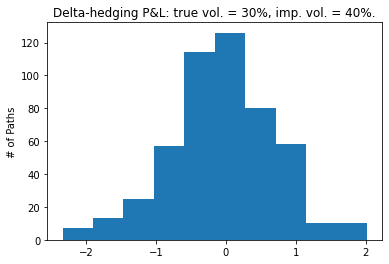

In [13]:
plt.hist(PandL_list)
plt.title("Delta-hedging P&L: true vol. = 30%, imp. vol. = 40%.")
plt.ylabel("# of Paths")
plt.savefig('40%.png', dpi=100)